# [ADA-2020]: P4-milestone
### Group project: Friendship and home position

**Objective**: Inspect the difference in quantity, quality and distribution of friends according to where a person lives

**Authors**: ADA Dream Team

**Study paper**: Eunjoon Cho, Seth A. Myers and Jure Leskovec, *Friendship and Mobility: User Movement in Location-Based Social Network*, Standford University, 2011

**Datasets**:
1. Gowalla dataset: https://snap.stanford.edu/data/loc-gowalla.html. A dataset from the paper. Checkins of users and friends relationship.
2. Brightkite dataset: https://snap.stanford.edu/data/loc-Brightkite.html. A dataset from the paper. Checkins of users and friends relationship.
3. Compilation of UNData: https://www.kaggle.com/sudalairajkumar/undata-country-profiles. Different characteristics for each country.
4. Compilation of USGovt: https://www.kaggle.com/fernandol/countries-of-the-world. More characteristics for each country.
5. happiness2020.pkl and countries_info.csv from "tutorial 01- Handling data", extracted from the World Happiness Report of the United Nations Sustainable Development Solution Network. More characteristics for each country.

**Method**: The method that will be used here is the following:

<span style="color:red">!! ADD WHOLE METHOD (SUMMARY)!!</span>

**Others**: 
The abstract as well as the research questions can be found on the README.md.

In [1]:
#Librairies

#General purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Convert country names to ISO codes
import pycountry 
import pycountry_convert 

#Convert longitudes and latitudes to country
import reverse_geocoder 

#Plot country map
import cartopy 
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.wkt as wkt
from shapely.geometry import MultiPolygon

#Library for map color to float
import matplotlib.cm as cm

#Library to normalize/standarize values
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Global constants
PATH = "data/"

## 0. Extraction of the data, preprocessing and merge
In this section, the different dataset will be loaded and preprocessed. Preprocess is the same as the one presented in the tutorial and in our previous milestone. The countries dataset will be merged together to form a big dataset with all the data about each country.

### 0.1 Users dataset
Gowalla and Brightkite are social networks. Their dataset are composed of checkins of each users (place, date, ...) and their friendship relations.

In [3]:
#Extraction parameters
EXTENSION = ".txt.gz"
SEPARATOR = "\t"
CHECKIN_COLUMNS_NAME = ["user", "check-in time", "latitude", "longitude", "location id"]
EDGE_COLUMNS_NAME = ["friend1", "friend2"]
#Extract dataframe from .txt.gz (tabulated separated without header)
user = "IDS"
if user == "ANDRES":
    gowalla_edges = pd.read_csv(PATH+"Gowalla_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"Gowalla_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    bright_edges = pd.read_csv(PATH+"Brightkite_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"Brightkite_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)

elif user == "IDS":
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
elif user == "THIB":
    print("Add your import")
else:
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)


#Remove from checkin some invalid points (null data and incoherent latitudes)
bright_0_lat = bright_checkins[bright_checkins["latitude"] == 0]
bright_0_lat_long = bright_0_lat[bright_0_lat["longitude"] == 0]
bright_checkins = bright_checkins.drop(bright_0_lat_long.index)
bright_big_lat = bright_checkins[bright_checkins["latitude"]>90]
bright_checkins = bright_checkins.drop(bright_big_lat.index)
bright_small_lat = bright_checkins[bright_checkins["latitude"]<-90]
bright_checkins = bright_checkins.drop(bright_small_lat.index)

gowalla_0_lat = gowalla_checkins[gowalla_checkins["latitude"] == 0]
gowalla_0_lat_long = gowalla_0_lat[gowalla_0_lat["longitude"] == 0]
gowalla_checkins = gowalla_checkins.drop(gowalla_0_lat_long.index)
gowalla_big_lat = gowalla_checkins[gowalla_checkins["latitude"]>90]
gowalla_checkins = gowalla_checkins.drop(gowalla_big_lat.index)
gowalla_small_lat = gowalla_checkins[gowalla_checkins["latitude"]<-90]
gowalla_checkins = gowalla_checkins.drop(bright_small_lat.index)

#Sample dataframe to analyze and verify structure
#bright_edges.sample(10)
bright_checkins.sample(10)
#gowalla_edges.sample(10)
#gowalla_checkins.sample(10)

,user,check-in time,latitude,longitude,location id
2369346,9617,2008-12-15T18:43:38Z,32.757463,-97.333163,e13ee52ccaa611dd92e8003048c10834
1496672,6139,2008-05-06T17:05:14Z,38.304389,-85.562418,addff698cd3efb467bcd643d35872a5a311854ad
4513952,43649,2009-11-12T20:18:43Z,60.364975,5.364944,cbe1d01268c711dea6f8003048c10834
4555752,45864,2009-05-31T08:17:44Z,55.702279,12.570498,99c964d24d4211de9f76003048c0801e
2552589,10560,2009-03-31T06:20:14Z,35.685000,139.751389,b9c114f2a22411dda217eb3127033598
323852,659,2010-05-01T17:05:51Z,37.768450,-122.394847,000f5e9739da3b6fc151fb13739f1efb
2300625,9162,2008-05-20T08:05:16Z,34.036035,-118.461314,22fa562d69a12fe6921b0a9dc5dc2ab8e61d4e30
934186,2845,2010-06-04T21:06:19Z,47.658842,-122.143199,9268ba78cc8f11ddbbee003048c0801e
3803154,23796,2009-03-04T00:37:49Z,42.902022,-78.876895,f905aec239c5885be5ae61593891a1c1bb9b767b
454560,1100,2008-07-14T22:55:13Z,-33.885658,151.213940,7b082c279e20a73529abcf319cce628ba2b04d40


### 0.2 Countries dataset
Three different dataset with informations about countries will be used. The first one is from the World Happiness Report of the United Nations Sustainable Development Solution Network, it was presented in the Tutorial of this class; it will be refered as country_WHR (for World Happiness Report). The second one is a compilation (from https://www.kaggle.com/sudalairajkumar/undata-country-profiles) of data from the UN (http://data.un.org/); it will refered as country_UN. The last one is also a compilation (https://www.kaggle.com/fernandol/countries-of-the-world) of data from the CIA (https://www.cia.gov/library/publications/the-world-factbook/); it will be refered as country_CIA.

First, we load and preprocess each one. Then we merge all their information into a big dataset; countries_features.

#### 0.2.1  World Happiness Report (WHR)

In [4]:
#Load data
countries = pd.read_csv(PATH+"countries_info.csv")
happiness = pd.read_pickle(PATH+"happiness2020.pkl")

#Lower case countries from happiness so merge will be possible
happiness["country"] = happiness["country"].str.lower()
#Change column name so they will merge (not duplicated) #!may exist a simpler alternative in the merge options
names = countries.columns.tolist()
names[names.index("country_name")] = "country"
countries.columns = names
#Merge
country_WHR = pd.merge(happiness, countries, left_on = "country", right_on = "country")

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_WHR = country_WHR.dropna(axis = 1)

#Restore first letter as upper case for latter use
country_WHR.country = country_WHR.country.str.title()

#Sample dataframe to analyze and verify structure
country_WHR.sample(4)

,country,happiness_score,social_support,healthy_life_expectancy,freedom_of_choices,generosity,perception_of_corruption,world_region,area,population
32,Dominican Republic,5.6892,0.882085,65.807487,0.866203,-0.131263,0.756000,Latin America and Caribbean,48730,9183984
91,Nigeria,4.7241,0.737217,49.861908,0.759578,0.033746,0.861874,Sub-Saharan Africa,923768,131859731
77,Mali,4.7293,0.731469,51.726982,0.711566,-0.044367,0.839328,Sub-Saharan Africa,1240000,11716829
52,Indonesia,5.2856,0.808380,62.155849,0.870614,0.519587,0.876296,Southeast Asia,1919440,245452739


#### 0.2.2  United Nation Compilation (UN)

In [5]:
#Converts the ratio string ("x/y") to the corresponding float
def string_div_to_float(my_string):
    try:
        num, denom = my_string.split('/')
        return float(num) / float(denom)
    except ValueError: #some of the data have ".../..." as a ratio...
        return -100

In [6]:
#Load data (Some datasets represents ratio as such strings "x/y", we will convert it with a float resulting of the division)
country_UN = pd.read_csv(PATH+"country_profile_variables.csv", converters={"Labour force participation (female/male pop. %)":string_div_to_float, "Life expectancy at birth (females/males, years)":string_div_to_float,"Education: Primary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float, "Education: Tertiary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"Population age distribution (0-14 / 60+ years, %)":string_div_to_float, "Forested area (% of land area)":string_div_to_float,"Education: Secondary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"International migrant stock (000/% of total pop.)":string_div_to_float,"Energy supply per capita (Gigajoules)":string_div_to_float,"Pop. using improved drinking water (urban/rural, %)":string_div_to_float})

#Treat some aberrations
country_UN = country_UN.replace("~0.0",0)
country_UN = country_UN.replace("...",np.nan)

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_UN = country_UN.dropna(axis = 1)

#Remove Guadeloupe and Mayotte that are french
country_UN = country_UN[country_UN.country != "Guadeloupe"]
country_UN = country_UN[country_UN.country != "Mayotte"]

#Sample dataframe to analyze and verify structure
country_UN.head(10)

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Seats held by women in national parliaments %,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI)
0,Afghanistan,SouthernAsia,652864,35530,54.4,106.3,20270,-2.4,623.2,23.3,...,0.278195,27.7,42,2.1,32.666667,63,5,1.663830,1.670370,-99
1,Albania,SouthernEurope,28748,2930,106.9,101.9,11541,2.6,3984.2,22.4,...,1.398357,22.9,130,28.2,2.850000,84,36,0.996849,1.058758,-99
2,Algeria,NorthernAfrica,2381741,41318,17.3,102.0,164779,3.8,4154.1,12.2,...,1.560554,31.6,135,0.8,39.297297,5900,55,1.030562,1.092457,-99
3,American Samoa,Polynesia,199,56,278.2,103.6,-99,-99,-99.0,-99,...,-100.000000,-99.0,92,87.9,-100.000000,-99,-99,1.000000,1.000000,-99
4,Andorra,SouthernEurope,468,77,163.8,102.3,2812,0.8,39896.4,0.5,...,-100.000000,32.1,13,34.0,0.078125,1,119,1.000000,1.000000,-99
5,Angola,MiddleAfrica,1246700,29784,23.9,96.2,117955,3.0,4714.1,6.8,...,0.788462,38.2,146,46.5,24.857143,3902,25,2.673759,3.937778,-99
6,Anguilla,Caribbean,91,15,165.7,97.6,320,2.9,21879.6,2.3,...,-100.000000,-99.0,52,61.1,0.010204,0,136,-100.000000,-100.000000,-99
7,Antigua and Barbuda,Caribbean,442,102,231.8,92.3,1356,4.1,14764.5,1.9,...,2.059603,11.1,55,22.3,0.086207,-99,84,1.000000,1.000000,-99
8,Argentina,SouthAmerica,2780400,44271,16.2,95.9,632343,2.4,14564.5,6.0,...,1.620472,38.9,256,10.0,43.404255,3167,85,0.990000,0.978637,-99
9,Armenia,WesternAsia,29743,2930,102.9,88.8,10529,3.0,3489.1,19.0,...,1.127404,9.9,114,11.7,3.055556,48,46,1.000000,1.230179,-99


#### 0.2.3  Central Intelligence Agency Compilation (CIA)

In [7]:
#Load data
country_CIA = pd.read_csv(PATH+"countries of the world.csv")

#Same country index name
country_CIA = country_CIA.rename(columns = {"Country":"country"})

#Change commas with dot
country_CIA = country_CIA.stack().str.replace(',','.').unstack()

#Remove Guadeloupe and Mayotte that are french and Virgin Islands that are american
country_CIA = country_CIA[country_CIA.country != "Guadeloupe "]
country_CIA = country_CIA[country_CIA.country != "Mayotte "]
country_CIA = country_CIA[country_CIA.country != "Virgin Islands "]

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_CIA = country_CIA.dropna(axis = 1)

#Sample dataframe to analyze and verify structure
country_CIA.sample(4)

,country,Region,Pop. Density (per sq. mi.),Coastline (coast/area ratio)
120,Lithuania,BALTICS,55.0,0.14
88,Guyana,LATIN AMER. & CARIB,3.6,0.21
193,Suriname,LATIN AMER. & CARIB,2.7,0.24
34,Cambodia,ASIA (EX. NEAR EAST),76.7,0.24


#### 0.2.4 Merge the three datasets
The three datasets will be merged in this section. To be able to merge them we need a common identifier, to do so we use the pycountry library. We did not found a library able to work with pandas so we have to do a lambda iteration, which is reasonable as the number of countries is not incredeibly large and we only do it once. 

Note that the WHR dataset is smaller than the two others. Also note that during this conversion some countries are not correctly identified and so are removed, however these countries are in most cases small islands or countries in development which may have very little nor no data for the networks dataset.

In [8]:
#from https://codereview.stackexchange.com/questions/238714/basic-function-to-convert-country-name-to-iso-code-using-pycountry
# convert country name in alpha 3 name
def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

In [9]:
#Change country names to alpha3 so they can be compared (takes ~ 1 minute)
country_WHR['alpha3_name'] = country_WHR.country.apply(lambda name: do_fuzzy_search(name))
country_UN['alpha3_name'] = country_UN.country.apply(lambda name: do_fuzzy_search(name))
country_CIA['alpha3_name'] = country_CIA.country.apply(lambda name: do_fuzzy_search(name))

#Remove the countries that received invalid alpha3 number
country_WHR = country_WHR.dropna()
country_UN = country_UN.dropna()
country_CIA = country_CIA.dropna()
#Nigeria and Niger have the same alpha3 code
country_WHR = country_WHR[country_WHR.alpha3_name != "NGA"] 
country_UN = country_UN[country_UN.alpha3_name != "NGA"]
country_CIA = country_CIA[country_CIA.alpha3_name != "NGA"]
#Same for best and worst Korea
country_WHR = country_WHR[country_WHR.alpha3_name != "PRK"] 
country_UN = country_UN[country_UN.alpha3_name != "PRK"]
country_CIA = country_CIA[country_CIA.alpha3_name != "PRK"]

#Remove the information repeated accross datasets
TO_REMOVE_WHR = ["healthy_life_expectancy", "world_region", "area", "population"]
TO_REMOVE_CIA = ["Region"]
country_WHR = country_WHR.drop(columns = TO_REMOVE_WHR)
country_CIA = country_CIA.drop(columns = TO_REMOVE_CIA)

In [10]:
#Merge the different datasets
countries_features = country_WHR.merge(country_UN, left_on = "alpha3_name", right_on = "alpha3_name", how="inner")
countries_features = countries_features.merge(country_CIA, left_on = "alpha3_name", right_on = "alpha3_name", how="inner")

#Change names and remove repeated columns
countries_features = countries_features.drop(columns = ["country_x"])
countries_features = countries_features.rename(columns = {"country_y":"country"})
countries_features = countries_features.loc[:, ~countries_features.columns.duplicated()]

#Sample dataframe to analyze and verify structure
countries_features.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3_name,country,Region,Surface area (km2),Population in thousands (2017),...,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI),Pop. Density (per sq. mi.),Coastline (coast/area ratio)
46,3.7208,0.593248,0.537825,0.400535,0.684767,HTI,Haiti,Caribbean,27750,10981,...,205,3.5,9.666667,136,16,1.363445,1.750000,-99,299.4,6.38
74,6.7728,0.930380,0.924911,0.214966,0.658547,MLT,Malta,SouthernEurope,315,431,...,39,1.1,0.410714,1,78,1.000000,1.000000,-99,1266.5,62.28
42,5.1480,0.728601,0.794797,0.094171,0.847965,GHA,Ghana,WesternAfrica,238537,28834,...,238,40.9,24.166667,410,14,1.102381,2.348837,-99,93.6,0.23
3,5.9747,0.900568,0.831132,-0.194914,0.842010,ARG,Argentina,SouthAmerica,2780400,44271,...,256,10.0,43.404255,3167,85,0.990000,0.978637,-99,14.4,0.18


From all the features we remove the ones that we consider uninteresting for our application or repeated in different ways (density of population and total population).

In [11]:
TO_REMOVE = ["Surface area (km2)","GDP: Gross domestic product (million current US$)", "Economy: Agriculture (% of GVA)","Economy: Industry (% of GVA)", "Economy: Services and other activity (% of GVA)","Agricultural production index (2004-2006=100)","Food production index (2004-2006=100)","Seats held by women in national parliaments %","Threatened species (number)","CO2 emission estimates (million tons/tons per capita)","Energy production, primary (Petajoules)","Pop. using improved drinking water (urban/rural, %)","Net Official Development Assist. received (% of GNI)"]
countries_features = countries_features.drop(columns=TO_REMOVE)

In the end, we have a dataset with 127 countries (there was 131 valid countries in the WHR dataset). In total there is 57 columns. So there is 55 features for each country, they are:

In [12]:
features = countries_features.columns
for feature in features:
    if(feature != "country" and feature != "alpha3_name"):
        print(feature)

happiness_score
social_support
freedom_of_choices
generosity
perception_of_corruption
Region
Population in thousands (2017)
Population density (per km2, 2017)
Sex ratio (m per 100 f, 2017)
GDP growth rate (annual %, const. 2005 prices)
GDP per capita (current US$)
Labour force participation (female/male pop. %)
Population growth rate (average annual %)
Urban population (% of total population)
Urban population growth rate (average annual %)
Life expectancy at birth (females/males, years)
Population age distribution (0-14 / 60+ years, %)
International migrant stock (000/% of total pop.)
Health: Total expenditure (% of GDP)
Education: Primary gross enrol. ratio (f/m per 100 pop.)
Education: Secondary gross enrol. ratio (f/m per 100 pop.)
Education: Tertiary gross enrol. ratio (f/m per 100 pop.)
Individuals using the Internet (per 100 inhabitants)
Forested area (% of land area)
Energy supply per capita (Gigajoules)
Pop. Density (per sq. mi.)
Coastline (coast/area ratio)


The country in our dataset are represented above (code copied by https://github.com/SciTools/cartopy/issues/1303 and exception error by https://stackoverflow.com/questions/63943614/python-cartopy-how-to-solve-polygon-object-error):

In [13]:
#Color a counter (indicated by its ISO code) in a color
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            except Exception as e:
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            return ax

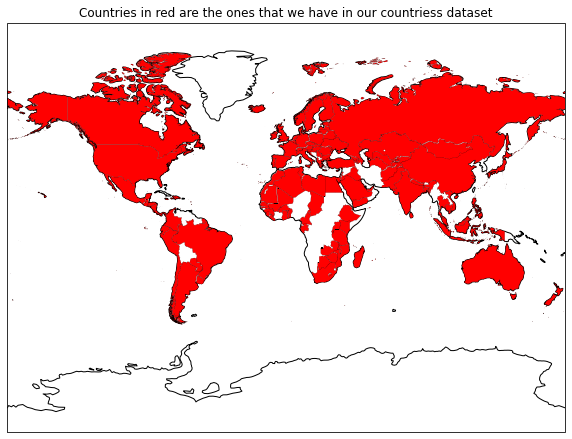

In [14]:
#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in countries_features.alpha3_name :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that we have in our countriess dataset")
plt.show()

## 1. Compute home position
Average the home position of the users. This is done like explained in the paper. The implementation is exactly the same as what was done for P2-milestone and so is not detailed and considered as an independent part (own libraries, constants, ...). The jupyter notebook that explain this can be found in the git under the name "replication_report".

In [15]:
#Librairies
from pyproj import Transformer #convert data from one type to another type

#Constants
SQUARE_SIZE = 25000

#Define the transformation from long-lat to x-y
trans = Transformer.from_crs(
    "epsg:4326", #long lat notation
    "epsg:3857", #pseudo mercator https://epsg.io/3857
    always_xy=True,
)

#Transform data long-lat -> x-y
bright_checkins["x"], bright_checkins["y"] = trans.transform(bright_checkins["longitude"].values, 
                                                             bright_checkins["latitude"].values)
gowalla_checkins["x"], gowalla_checkins["y"] = trans.transform(gowalla_checkins["longitude"].values, 
                                                             gowalla_checkins["latitude"].values)

#Some checkins at extreme values cannot be converted due to the projection -> remove them
bright_checkins = bright_checkins.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
gowalla_checkins = gowalla_checkins.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

#find square position to which the point belongs (take the divisor of the euclidian division) 
#(!i_x/i_y may be negative because the origin is at the center of Earth (Null Island))
bright_checkins["i_x"] = (bright_checkins["x"]/SQUARE_SIZE).astype(int)
bright_checkins["i_y"] = (bright_checkins["y"]/SQUARE_SIZE).astype(int)
gowalla_checkins["i_x"] = (gowalla_checkins["x"]/SQUARE_SIZE).astype(int)
gowalla_checkins["i_y"] = (gowalla_checkins["y"]/SQUARE_SIZE).astype(int)

#Now we can drop x, y, latitude and longitude
TO_REMOVE = ["latitude", "longitude","x"] #keep one column for the count
bright_checkins_light = bright_checkins.drop(columns=TO_REMOVE)
gowalla_checkins_light = gowalla_checkins.drop(columns=TO_REMOVE)
bright_checkins_light = bright_checkins_light.rename(columns={"y":"count"})
gowalla_checkins_light = gowalla_checkins_light.rename(columns={"y":"count"})

#For each user find the most used square

#Group by user and square position and count the nb of occurence
bright_checkins_zone_count = bright_checkins_light.groupby(["user","i_x","i_y"]).count().reset_index()
#create a dataframe with the max value
bright_checkins_zone_max = bright_checkins_zone_count.groupby(["user"]).max() \
                           .rename(columns={"count":"count_max"}).drop(columns=["i_x", "i_y"])
#merge both dataframes
bright_checkins_merge = pd.merge(bright_checkins_zone_max, bright_checkins_zone_count, left_on="user",right_on="user")
#keep only the lines where the count is equal to the maximum
bright_checkins_home = bright_checkins_merge[(bright_checkins_merge["count_max"] == bright_checkins_merge["count"])]
#There may be still some duplicates if tie (keep first)
bright_checkins_home = bright_checkins_home.drop_duplicates(subset=["user"],keep="first")
#by rehandling the dataframe we have for each user it's prefered square
bright_square_home = bright_checkins_home.drop(columns=["count_max","count"]).set_index("user")

#Group by user and square position and count the nb of occurence
gowalla_checkins_zone_count = gowalla_checkins_light.groupby(["user","i_x","i_y"]).count().reset_index()
#create a dataframe with the max value
gowalla_checkins_zone_max = gowalla_checkins_zone_count.groupby(["user"]).max() \
                           .rename(columns={"count":"count_max"}).drop(columns=["i_x", "i_y"])
#merge both dataframes
gowalla_checkins_merge = pd.merge(gowalla_checkins_zone_max, gowalla_checkins_zone_count, left_on="user",right_on="user")
#keep only the nb of checkins of the square is equal to the maximum
gowalla_checkins_home = gowalla_checkins_merge[(gowalla_checkins_merge["count_max"] == gowalla_checkins_merge["count"])]
#There may be still some duplicates if tie (keep first)
gowalla_checkins_home = gowalla_checkins_home.drop_duplicates(subset=["user"],keep="first")
#by rehandling the dataframe we have for each user it's prefered square
gowalla_square_home = gowalla_checkins_home.drop(columns=["count_max","count"]).set_index("user")

#For each row add the home square of the user
bright_checkins_full = pd.merge(bright_checkins, bright_square_home, left_on="user", 
                                right_index=True, how="outer", suffixes=('', '_h'))
gowalla_checkins_full = pd.merge(gowalla_checkins, gowalla_square_home, left_on="user", 
                                right_index=True, how="outer", suffixes=('', '_h'))

#Remove checkins not in home square
bright_home_checkins = bright_checkins_full[(bright_checkins_full["i_x"] == bright_checkins_full["i_x_h"]) 
                                            & (bright_checkins_full["i_y"] == bright_checkins_full["i_y_h"])]
gowalla_home_checkins = gowalla_checkins_full[(gowalla_checkins_full["i_x"] == gowalla_checkins_full["i_x_h"]) 
                                            & (gowalla_checkins_full["i_y"] == gowalla_checkins_full["i_y_h"])]

#Remove useless columns
TO_REMOVE = ["i_x", "i_y", "i_x_h", "i_y_h", "longitude", "latitude"]
bright_home_checkins_light = bright_home_checkins.drop(columns=TO_REMOVE)
gowalla_home_checkins_light = gowalla_home_checkins.drop(columns=TO_REMOVE)

#Mean the position for each user
bright_home_pos = bright_home_checkins_light.groupby(["user"]).mean()
gowalla_home_pos = gowalla_home_checkins_light.groupby(["user"]).mean()

#Define the transformation from x-y to long-lat (return to long lat for more precise distance mesure) (linear trans -> ok)
trans = Transformer.from_crs(
    "epsg:3857", #pseudo mercator https://epsg.io/3857
    "epsg:4326", #long lat notation
    always_xy=True,
)

#Transform data from x-y to long-lat
long, lat = trans.transform(bright_home_pos["x"].values, bright_home_pos["y"].values)
bright_home_pos["lat"] = lat
bright_home_pos["long"] = long
long, lat = trans.transform(gowalla_home_pos["x"].values, gowalla_home_pos["y"].values)
gowalla_home_pos["lat"] = lat
gowalla_home_pos["long"] = long

#Now we can drop x and y
TO_REMOVE = ["x", "y", "check-in time_x", "check-in time_y", "location id_x", "location id_y"]
bright_home_pos_light = bright_home_pos.drop(columns=TO_REMOVE)
gowalla_home_pos_light = gowalla_home_pos.drop(columns=TO_REMOVE)
gowalla_home_pos_light = gowalla_home_pos_light.drop(columns="location id")

In [16]:
#Sample dataframe to analyze and verify structure
#bright_home_pos_light.sample(4)
gowalla_home_pos_light.sample(4)

,lat,long
user,,
89606,55.696822,13.186324
52515,45.361097,-75.712728
62655,33.961676,-84.505460
27643,33.744489,-84.388258


## 2. Compute nationality and remove non used countries

### 2.1 Compute nationality of the users
Convert longitude latitude to country. To do so we use the reverse_geocoder library.

In [17]:
#convert country name in alpha 2 name (one library return alpha2 from long lat, not country name)
def alpha2_to_country(alpha2_code):
    try:
        result = pycountry_convert.country_alpha2_to_country_name(alpha2_code)
    except Exception:
        result = np.nan
    return result

In [18]:
#Create new dataset
bright_home_complete = bright_home_pos_light
gowalla_home_complete = gowalla_home_pos_light

#Convert long-lat peer in tupple so it is easier for the library
bright_longlat_tupple = list(zip(bright_home_pos_light.lat, bright_home_pos_light.long))
gowalla_longlat_tupple = list(zip(gowalla_home_pos_light.lat, gowalla_home_pos_light.long))

#Search the localisation of each datapoint
bright_home_complete["loc"] = reverse_geocoder.search(bright_longlat_tupple)
gowalla_home_complete["loc"] = reverse_geocoder.search(gowalla_longlat_tupple)

#Separate the localisation information in the different part (name of the city, admin district, country code)
bright_home_complete = pd.DataFrame(bright_home_complete['loc'].tolist(), index=bright_home_complete.index)
gowalla_home_complete = pd.DataFrame(gowalla_home_complete['loc'].tolist(), index=gowalla_home_complete.index)

#Convert country code to country name
bright_home_complete['country'] = bright_home_complete.cc.apply(lambda cc: alpha2_to_country(cc))
gowalla_home_complete['country'] = gowalla_home_complete.cc.apply(lambda cc: alpha2_to_country(cc))

#Remove the useless columns
TO_REMOVE = ["name","admin1","admin2","cc","lat","lon"]
bright_nat = bright_home_complete.drop(columns = TO_REMOVE)
gowalla_nat = gowalla_home_complete.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
bright_nat.sample(4)
#gowalla_nat.sample(4)

Loading formatted geocoded file...


,country
user,
6861,United States
20991,United States
41342,Mexico
56432,Estonia


### 2.2 Find less used countries and remove them
To decide whatever we keep or not a country we compute its users density (sum of the two applications). 

The minimum density is set to 1 person over 100'000 in one country that have th application. It may seem very few, however the dataset has very low density for all countries (see plot and description above, only green are availible with our density) and we need to have at least some countries to compare.

<span style="color:red">DISCUSS THIS CHOICE</span> 

In [19]:
#Count the users of each country
bright_countries_count = bright_home_complete.country.value_counts()
gowalla_countries_count = gowalla_home_complete.country.value_counts()
#Add alpha3 code for merging
l_idx = []
for idx in bright_countries_count.index:
    l_idx.append(do_fuzzy_search(idx))
bright_count = pd.DataFrame(bright_countries_count)
bright_count["alpha3_name"] = l_idx
l_idx = []
for idx in gowalla_countries_count.index:
    l_idx.append(do_fuzzy_search(idx))
gowalla_count = pd.DataFrame(gowalla_countries_count)
gowalla_count["alpha3_name"] = l_idx

#Remove some colonies or duplicated codes... (detected with bright_count.alpha3_name.duplicated())
bright_count = bright_count[bright_count.index != "Nigeria"]
bright_count = bright_count[bright_count.index != "Niger"]
bright_count = bright_count[bright_count.index != "Curaçao"]
bright_count = bright_count[bright_count.index != "Guadeloupe"]

In [20]:
#Do a safety guard
countries_features_temp = countries_features

#Add the number of users to the countries features
countries_features_temp = countries_features_temp.merge(bright_count, left_on = "alpha3_name", right_on = "alpha3_name", how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"country_x":"country"})
countries_features_temp = countries_features_temp.rename(columns = {"country_y":"bright_count"})
countries_features_temp = countries_features_temp.merge(gowalla_count, left_on = "alpha3_name", right_on = "alpha3_name", how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"country_x":"country"})
countries_features_temp = countries_features_temp.rename(columns = {"country_y":"gowalla_count"})
#Replace the NaN values to 0
countries_features_temp = countries_features_temp.fillna(0)

#Sum the users of each application
countries_features_temp["users"] = countries_features_temp["bright_count"] + countries_features_temp["gowalla_count"]
#Compute the density of users in the population
countries_features_temp["density_users"] = countries_features_temp["users"]/(countries_features_temp["Population in thousands (2017)"]*1000)

count    1.270000e+02
mean     4.359306e-05
std      1.863250e-04
min      0.000000e+00
25%      1.730598e-07
50%      1.578898e-06
75%      1.958827e-05
max      1.892947e-03
Name: density_users, dtype: float64


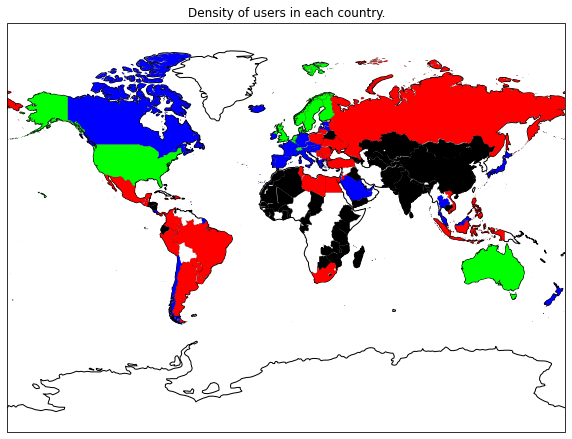

In [21]:
# Plot the density distribution (add Alpha 3 just for the plot)
temp = countries_features_temp.copy()
temp['alpha3_name'] = temp.country.apply(lambda name: do_fuzzy_search(name))

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.density_users > 1e-4):
        color = (0,1,0)
    elif(t.density_users > 1e-5):
        color = (0,0,1)
    elif(t.density_users > 1e-6):
        color = (1,0,0)
    area(ax, t.alpha3_name, color)
    
plt.title("Density of users in each country.")
print(temp.density_users.describe())

In [22]:
#Parameter
MIN_DENSITY = 1e-5

#keep only the countries that have a minimum density of users
countries_features_clean = countries_features_temp[countries_features_temp["density_users"] > MIN_DENSITY]
valid_countries_alpha3 = countries_features_clean.alpha3_name.values

#Remove the useless columns
TO_REMOVE = ["bright_count", "gowalla_count","users","density_users","Population in thousands (2017)"]
countries_features_clean = countries_features_clean.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
countries_features_clean.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3_name,country,Region,"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",...,International migrant stock (000/% of total pop.),Health: Total expenditure (% of GDP),Education: Primary gross enrol. ratio (f/m per 100 pop.),Education: Secondary gross enrol. ratio (f/m per 100 pop.),Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Individuals using the Internet (per 100 inhabitants),Forested area (% of land area),Energy supply per capita (Gigajoules),Pop. Density (per sq. mi.),Coastline (coast/area ratio)
54,7.1286,0.913571,0.747581,0.102594,0.780855,ISR,Israel,WesternAsia,384.5,98.7,...,80.791165,7.8,1.006705,1.009804,1.382784,174,7.975309,1.0,305.8,1.31
57,5.8708,0.883546,0.809961,-0.246910,0.654558,JPN,Japan,EasternAsia,349.7,95.4,...,1277.437500,10.2,0.999013,1.002953,0.926941,404,126.458333,1.0,337.4,7.87
29,6.9109,0.914431,0.818537,-0.230862,0.858446,CZE,Czechia,EasternEurope,137.5,96.7,...,106.605263,7.4,1.003012,1.009515,1.407749,53,10.489130,1.0,129.8,0.00
102,6.2806,0.922494,0.749953,-0.124409,0.918096,SVK,Slovakia,EasternEurope,113.3,94.6,...,53.696970,8.1,0.990020,1.007600,1.545455,54,5.482143,1.0,111.4,0.00


There are 127 countries availible.


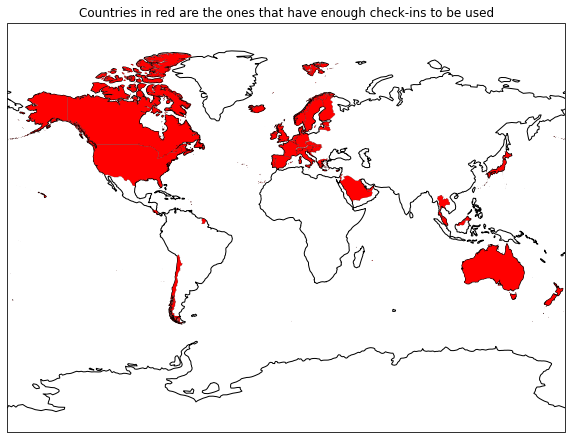

In [23]:
# Plot the countries in the final dataset (add Alpha 3 just for the plot)
temp = countries_features_clean
temp['alpha3_name'] = temp.country.apply(lambda name: do_fuzzy_search(name))

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in temp.alpha3_name :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that have enough check-ins to be used")
print("There are "+str(countries_features_temp.shape[0])+" countries availible.")
plt.show()

The final number of country is low, but we have to have meaningful results.

### 2.3 Cluster the countries
Try to find if some groups emerge from the countries' features. First data will be normalized (with a StandrardScaler), then we will use k-means with a set of k-values to find the optimal number of clusters. Finally, we show the emerging clusters.

In [24]:
#Libraries
from sklearn import preprocessing
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors

In [25]:
#Generate a list of colors for the plots
colors = mcolors.BASE_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]
color_names.remove("w") #pop white
color_names.extend(["gray","brown","orange","lightgreen","cyan"])
NB_MAX_GRP = len(color_names)

In [26]:
#Save the indetificators that we need
countries_names = countries_features_clean.country
countires_codes = countries_features_clean.alpha3_name

#Remove the information that can not be used for clustering
TO_REMOVE = ["country","alpha3_name","Region"]
country_clustering = countries_features_clean.drop(columns=TO_REMOVE)

#Standarize the data ((x-mean)/var)
scaler = preprocessing.StandardScaler()
country_clustering = pd.DataFrame(scaler.fit_transform(country_clustering))

Text(0, 0.5, 'RMS')

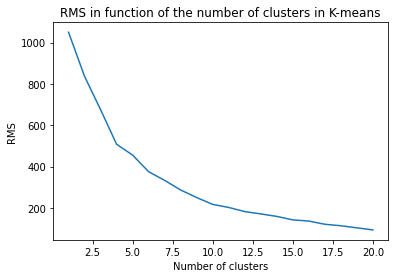

In [27]:
#Initialize the variables
all_rms = []
NB_MAX_CENTROIDS = 21

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    kmeans = KMeans(n_clusters=nb_centroids).fit(country_clustering)
    all_rms.append(kmeans.inertia_)
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_rms)
plt.title("RMS in function of the number of clusters in K-means")
plt.xlabel("Number of clusters")
plt.ylabel("RMS")

From the plot we see that the elbow occurs around 7 clusters.

In [28]:
#Compute with our best resut
BEST_NB_CLUSTERS = 7
kmeans = KMeans(n_clusters=BEST_NB_CLUSTERS, n_init = 100).fit(country_clustering)
labels = kmeans.labels_
res = pd.DataFrame(index = countries_names, data = labels, columns =["labels"])

In [29]:
#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)

features_clusters = res

Label n°0
['Chile' 'Costa Rica' 'Croatia' 'Cyprus' 'Czechia' 'Estonia' 'France'
 'Greece' 'Hungary' 'Italy' 'Japan' 'Latvia' 'Portugal' 'Slovakia'
 'Slovenia' 'Spain' 'Thailand']
Label n°1
['Australia' 'Austria' 'Belgium' 'Canada' 'Denmark' 'Finland' 'Germany'
 'Iceland' 'Israel' 'Luxembourg' 'Malta' 'Netherlands' 'New Zealand'
 'Norway' 'Sweden' 'Switzerland' 'United Kingdom']
Label n°2
['Singapore']
Label n°3
['Bahrain' 'Kuwait' 'Malaysia' 'Saudi Arabia']
Label n°4
['United Arab Emirates']
Label n°5
['United States of America']
Label n°6
['Ireland']


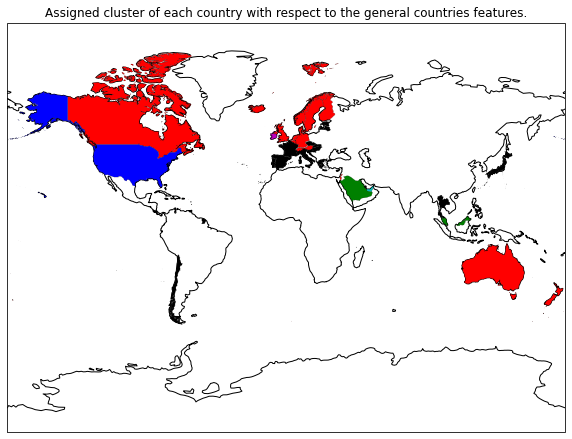

In [30]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, countires_codes.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the general countries features.")

## 3. Friends charachteristics

### 3.1 Compute

In [31]:
# Adding to the datasets the nationality of each friend
gowalla_edges = gowalla_edges.set_index("friend1")
gowalla_edges["friend1_nat"] = gowalla_nat["country"]
gowalla_edges = gowalla_edges.reset_index().set_index("friend2")
gowalla_edges["friend2_nat"] = gowalla_nat["country"]
gowalla_edges = gowalla_edges.reset_index()

bright_edges = bright_edges.set_index("friend1")
bright_edges["friend1_nat"] = bright_nat["country"]
bright_edges = bright_edges.reset_index().set_index("friend2")
bright_edges["friend2_nat"] = bright_nat["country"]
bright_edges = bright_edges.reset_index()

# Dropping those edges which have al least one node with Nan nationality
gowalla_edges = gowalla_edges.dropna()
bright_edges = bright_edges.dropna()

#bright_edges.sample(5)
gowalla_edges.sample(5)

,friend2,friend1,friend1_nat,friend2_nat
30560,15218,220,United States,Belgium
1715066,173805,132619,Sweden,Sweden
572856,52745,10692,United Kingdom,United Kingdom
482820,2378,7614,United States,United Kingdom
656064,98929,14989,Germany,Turkey


In [32]:
# Add the home of each users
#FIRST THE LATITUDE AND LONGITUDE OF THE FIRST USER IS OBTAINED SETTING THIS USER AS THE INDEX AND USING THE "Go_home" DATA FRAME
gowalla_edges = gowalla_edges.set_index("friend1")
gowalla_edges["friend1_lat"] = gowalla_home_pos_light["lat"]
gowalla_edges["friend1_lon"] = gowalla_home_pos_light["long"]
#THEN THE PROCESS IS REPEATED FOR THE SECOND USER
gowalla_edges = gowalla_edges.reset_index().set_index("friend2")
gowalla_edges["friend2_lat"] = gowalla_home_pos_light["lat"]
gowalla_edges["friend2_lon"] = gowalla_home_pos_light["long"]
#FINALLY THE INDEX IS RESETED SO THAT ALL INFORMATION IS EQUALLY ACCESIBLE
gowalla_edges = gowalla_edges.reset_index()

#SAME FOR BRIGHTKITE DATASET
bright_edges = bright_edges.set_index("friend1")
bright_edges["friend1_lat"] = bright_home_pos_light["lat"]
bright_edges["friend1_lon"] = bright_home_pos_light["long"]
bright_edges = bright_edges.reset_index().set_index("friend2")
bright_edges["friend2_lat"] = bright_home_pos_light["lat"]
bright_edges["friend2_lon"] = bright_home_pos_light["long"]
bright_edges = bright_edges.reset_index()

In [33]:
#Compute the distance btw the home of the users

# approximate radius of earth in km
R = 6373.0

# Converting grades to radians
gowalla_edges["friend1_lat"] = np.radians(gowalla_edges["friend1_lat"])
gowalla_edges["friend2_lat"] = np.radians(gowalla_edges["friend2_lat"])
gowalla_edges["friend1_lon"] = np.radians(gowalla_edges["friend1_lon"])
gowalla_edges["friend2_lon"] = np.radians(gowalla_edges["friend2_lon"])

# Calculating the difference between latitudes and longitudes
gowalla_edges["lat_dis"] = gowalla_edges["friend2_lat"]-gowalla_edges["friend1_lat"]
gowalla_edges["lon_dis"] = gowalla_edges["friend2_lon"]-gowalla_edges["friend1_lon"]

# Haversine method to compute the distance
gowalla_edges["a"] = np.sin(gowalla_edges["lat_dis"] / 2)**2 + np.cos(gowalla_edges["friend1_lat"]) * np.cos(gowalla_edges["friend2_lat"]) * np.sin(gowalla_edges["lon_dis"] / 2)**2
gowalla_edges["c"] = 2 * np.arctan2(np.sqrt(gowalla_edges["a"]), np.sqrt(1 - gowalla_edges["a"]))

gowalla_edges["distance"] = R * gowalla_edges["c"]


# Same for Brightkite dataset
bright_edges["friend1_lat"] = np.radians(bright_edges["friend1_lat"])
bright_edges["friend2_lat"] = np.radians(bright_edges["friend2_lat"])
bright_edges["friend1_lon"] = np.radians(bright_edges["friend1_lon"])
bright_edges["friend2_lon"] = np.radians(bright_edges["friend2_lon"])

bright_edges["lat_dis"] = bright_edges["friend2_lat"]-bright_edges["friend1_lat"]
bright_edges["lon_dis"] = bright_edges["friend2_lon"]-bright_edges["friend1_lon"]



bright_edges["a"] = np.sin(bright_edges["lat_dis"] / 2)**2 + np.cos(bright_edges["friend1_lat"]) * np.cos(bright_edges["friend2_lat"]) * np.sin(bright_edges["lon_dis"] / 2)**2
bright_edges["c"] = 2 * np.arctan2(np.sqrt(bright_edges["a"]), np.sqrt(1 - bright_edges["a"]))

bright_edges["distance"] = R * bright_edges["c"]

In [34]:
threshold = 50 #km between users

In [35]:
# Creating a new data set with friendship info for each user
# Number of friends
gowalla_friends_ch = pd.DataFrame(gowalla_edges.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
# Number of friends in the same country
gowalla_friends_ch["n_friends_same_country"] = gowalla_edges[gowalla_edges.friend1_nat == gowalla_edges.friend2_nat].groupby("friend1")["friend2"].count()
# Ratio of friends in the same country
gowalla_friends_ch["ratio_friends_same_country"] = gowalla_friends_ch["n_friends_same_country"]/gowalla_friends_ch["n_friends"]
# Number of friends within a distance
gowalla_friends_ch["n_friends_near"] = gowalla_edges[gowalla_edges.distance < threshold].groupby("friend1")["friend2"].count()
# Ratio of friends within a distance
gowalla_friends_ch["ratio_friends_near"] = gowalla_friends_ch["n_friends_near"]/gowalla_friends_ch["n_friends"]

# Same for Brightkite dataset
bright_friends_ch = pd.DataFrame(bright_edges.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
bright_friends_ch["n_friends_same_country"] = bright_edges[bright_edges.friend1_nat == bright_edges.friend2_nat].groupby("friend1")["friend2"].count()
bright_friends_ch["ratio_friends_same_country"] = bright_friends_ch["n_friends_same_country"]/bright_friends_ch["n_friends"]
bright_friends_ch["n_friends_near"] = bright_edges[bright_edges.distance < threshold].groupby("friend1")["friend2"].count()
bright_friends_ch["ratio_friends_near"] = bright_friends_ch["n_friends_near"]/bright_friends_ch["n_friends"]

gowalla_friends_ch = gowalla_friends_ch.fillna(0)
bright_friends_ch = bright_friends_ch.fillna(0)

# Filling Nan values (due to .count() function) with zeros
#bright_friends_ch.sample(5)
gowalla_friends_ch.sample(5)

,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
friend1,,,,,
158665,6,4.0,0.666667,4.0,0.666667
149679,1,0.0,0.000000,0.0,0.000000
82822,4,4.0,1.000000,2.0,0.500000
75242,2,2.0,1.000000,2.0,1.000000
157584,2,2.0,1.000000,2.0,1.000000


### 3.2 Merge the two dataset and add it to the country dataset

In [36]:
#Add the nationality of each user
bright_friends_nat = pd.merge(bright_friends_ch, bright_nat, left_index = True, right_index = True)
gowalla_friends_nat = pd.merge(gowalla_friends_ch, gowalla_nat, left_index = True, right_index = True)

#Groupby country and do the mean of each feature
bright_countries_friendships =  bright_friends_nat.groupby(["country"]).mean().reset_index()
gowalla_countries_friendships =  gowalla_friends_nat.groupby(["country"]).mean().reset_index()

#Add the alpha3 code and keep only the countries that are in the country dataset
bright_countries_friendships["alpha3_name"] = bright_countries_friendships.country.apply(lambda name: do_fuzzy_search(name))
bright_countries_friendships = bright_countries_friendships[bright_countries_friendships['alpha3_name'].isin(valid_countries_alpha3)]
gowalla_countries_friendships["alpha3_name"] = gowalla_countries_friendships.country.apply(lambda name: do_fuzzy_search(name))
gowalla_countries_friendships = gowalla_countries_friendships[gowalla_countries_friendships['alpha3_name'].isin(valid_countries_alpha3)]

#Remove useless informations
TO_REMOVE = ["n_friends_same_country", "n_friends_near"]
bright_countries_friendships = bright_countries_friendships.drop(columns = TO_REMOVE)
gowalla_countries_friendships = gowalla_countries_friendships.drop(columns = TO_REMOVE)

In [37]:
#Group Gowalla and Brightkite information (do the mean for ratio and the sum for friends)
full_countries_friendships = pd.merge(bright_countries_friendships, gowalla_countries_friendships, left_on ="alpha3_name", right_on = "alpha3_name")
full_countries_friendships["ratio_friends_near"] = (full_countries_friendships["ratio_friends_near_x"]+full_countries_friendships["ratio_friends_near_y"])/2
full_countries_friendships["ratio_friends_same_country"] = (full_countries_friendships["ratio_friends_same_country_x"]+full_countries_friendships["ratio_friends_same_country_y"])/2
full_countries_friendships["total_nb_friends"] = (full_countries_friendships["n_friends_x"]+full_countries_friendships["n_friends_y"])

#Remove or rename information
TO_REMOVE = ["country_y","ratio_friends_near_x","ratio_friends_same_country_x","n_friends_x", "ratio_friends_near_y","ratio_friends_same_country_y","n_friends_y"]
full_countries_friendships = full_countries_friendships.drop(columns = TO_REMOVE)
full_countries_friendships = full_countries_friendships.rename(columns = {"country_x":"country"})
full_countries_friendships = full_countries_friendships[full_countries_friendships.country != "Guadeloupe"]
full_countries_friendships = full_countries_friendships[full_countries_friendships.country != "Curaçao"]

In [38]:
#Give new names for future use
countries_friendships_features = full_countries_friendships
countries_other_features = countries_features_clean

#Merge merged information about friendship and countries features
countries_all_features = pd.merge(countries_friendships_features, countries_other_features, left_on="alpha3_name", right_on="alpha3_name")
countries_all_features = countries_all_features.drop(columns = ["country_y"])
countries_all_features = countries_all_features.rename(columns = {"country_x":"country"})

#Example
full_countries_friendships.sample(5)

,country,alpha3_name,ratio_friends_near,ratio_friends_same_country,total_nb_friends
13,Estonia,EST,0.564075,0.681075,13.068627
27,Luxembourg,LUX,0.782302,0.747705,13.344794
36,Slovenia,SVN,0.563605,0.674539,8.285714
35,Slovakia,SVK,0.328691,0.415634,9.703846
6,Costa Rica,CRI,0.630781,0.630781,8.685185


### 3.3 Plot the friendship features

Text(0.5, 1.0, 'Ratio of friends near to the user (higher is lighter)')

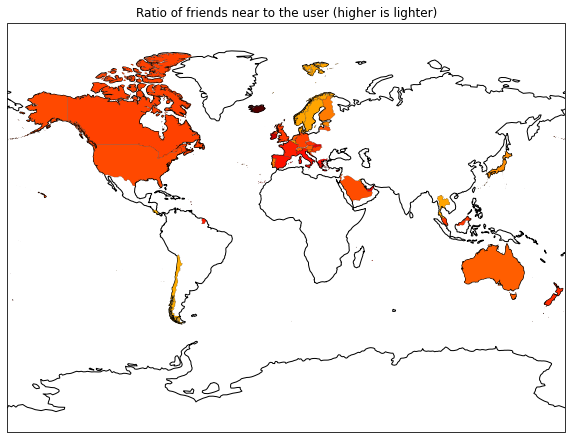

In [40]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Plot all countries
for i in range(0, full_countries_friendships.shape[0]) :
    color = cm.hot(full_countries_friendships.iloc[i].ratio_friends_near)
    area(ax, full_countries_friendships.iloc[i].alpha3_name, color)

plt.title("Ratio of friends near to the user (higher is lighter)")

Text(0.5, 1.0, 'Ratio of friends in the same country (higher is lighter)')

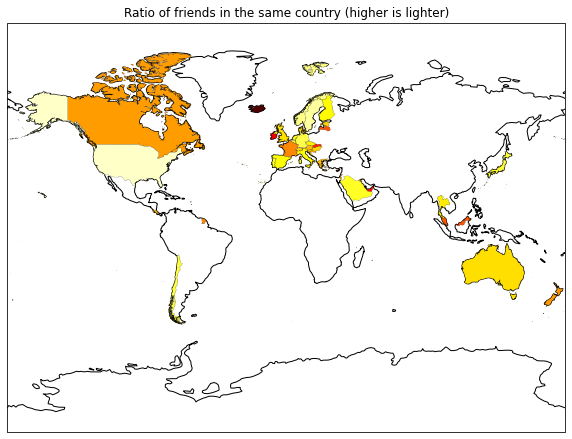

In [41]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Plot all countries
for i in range(0, full_countries_friendships.shape[0]) :
    color = cm.hot(full_countries_friendships.iloc[i].ratio_friends_same_country)
    area(ax, full_countries_friendships.iloc[i].alpha3_name, color)

plt.title("Ratio of friends in the same country (higher is lighter)")

Text(0.5, 1.0, 'Mean number of friends (higher is lighter)')

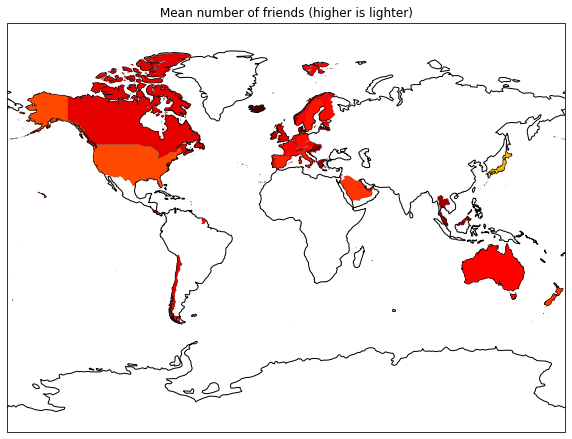

In [42]:
#Min max the value to be printable
scaler = MinMaxScaler()
temp = full_countries_friendships.copy()
temp["total_nb_friends"] = scaler.fit_transform((temp["total_nb_friends"].values).reshape(-1,1))

#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Plot all countries
for i in range(0, temp.shape[0]) :
    color = cm.hot(temp.iloc[i].total_nb_friends)
    area(ax, temp.iloc[i].alpha3_name, color)

plt.title("Mean number of friends (higher is lighter)")

### 3.4 Cluster the friendship informations

In [43]:
#Save id of countries
f_countries_names = full_countries_friendships.country
f_countries_alpha3 =  full_countries_friendships.alpha3_name

#Remove useless information
TO_REMOVE = ["country","alpha3_name"]
countries_friendships = full_countries_friendships.drop(columns = TO_REMOVE)

#Standarize the data ((x-mean)/var)
scaler = preprocessing.StandardScaler()
countries_friendships = pd.DataFrame(scaler.fit_transform(countries_friendships))

Text(0, 0.5, 'RMS')

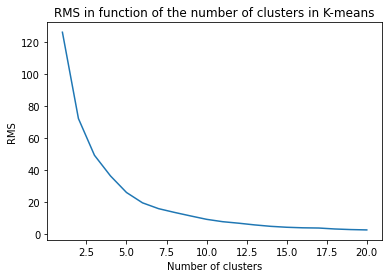

In [44]:
#Initialize the variables
all_rms = []
NB_MAX_CENTROIDS = 21

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    kmeans = KMeans(n_clusters=nb_centroids).fit(countries_friendships)
    all_rms.append(kmeans.inertia_)
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_rms)
plt.title("RMS in function of the number of clusters in K-means")
plt.xlabel("Number of clusters")
plt.ylabel("RMS")

The elbow is around 5 clusters.

In [45]:
#Compute with our best resut
BEST_NB_CLUSTERS = 5
kmeans = KMeans(n_clusters=BEST_NB_CLUSTERS, n_init = 100).fit(countries_friendships)
labels = kmeans.labels_
res = pd.DataFrame(index = f_countries_names, data = labels, columns =["labels"])

#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)
    
f_friendships_clusters = res

Label n°0
['Belgium' 'Chile' 'Finland' 'Japan' 'Luxembourg' 'Norway' 'Portugal'
 'Sweden' 'United States']
Label n°1
['Bahrain' 'Iceland' 'Ireland' 'Malta' 'Slovakia' 'United Arab Emirates']
Label n°2
['Costa Rica' 'Denmark' 'Hungary' 'Kuwait' 'Latvia' 'Malaysia' 'Singapore'
 'Slovenia' 'Thailand']
Label n°3
['Australia' 'Austria' 'Canada' 'Croatia' 'Netherlands' 'Czechia'
 'Estonia' 'France' 'Germany' 'Greece' 'Israel' 'Italy' 'New Zealand'
 'Saudi Arabia' 'Spain' 'Switzerland' 'United Kingdom']
Label n°4
['Cyprus']


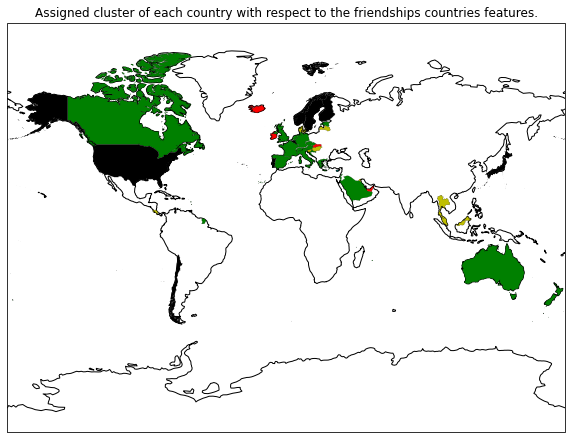

In [46]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, f_countries_alpha3.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the friendships countries features.")

### 3.5 Compare clustering in country features and friendship features

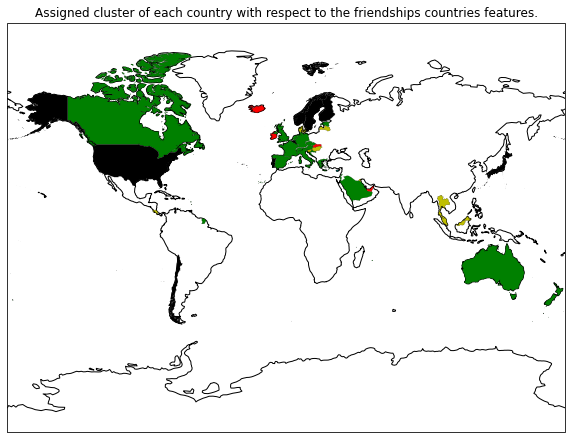

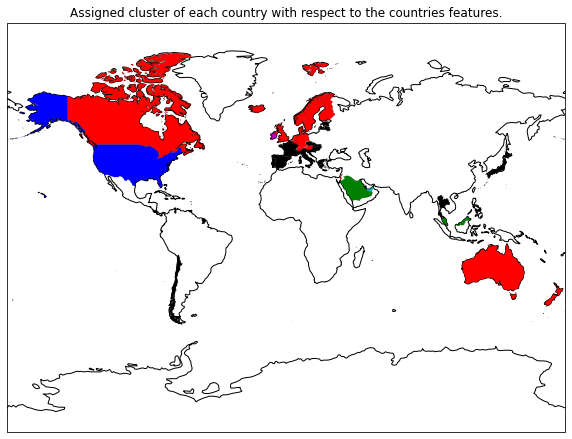

In [47]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(f_friendships_clusters.labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(f_friendships_clusters)) :
        label = f_friendships_clusters.iloc[i].values[0]
        color = color_names[label]
        area(ax, f_countries_alpha3.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the friendships countries features.")
    
    
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(features_clusters.labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(features_clusters)) :
        label = features_clusters.iloc[i].values[0]
        color = color_names[label]
        area(ax, countires_codes.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the countries features.")

The first interesting discovery is that there is less clusters for friendship than for country features.

We can also see that some of the countries stay with the same country. That may indicate a relationship.

But no obvious correlation